# 1st try - 005930.KS.CSV / samsung

---
Step 1 : 데이터 준비  

---

In [1]:
import pandas
import sklearn
import statsmodels

from google.colab import drive
drive.mount('/content/drive')

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1.3.5
1.0.2
0.12.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = '/content/drive/MyDrive/Exploration/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [3]:
print(type(ts))

<class 'pandas.core.series.Series'>


Date 컬럼을 index_col로 지정하고 시계열 데이터임을 확인했습니다.

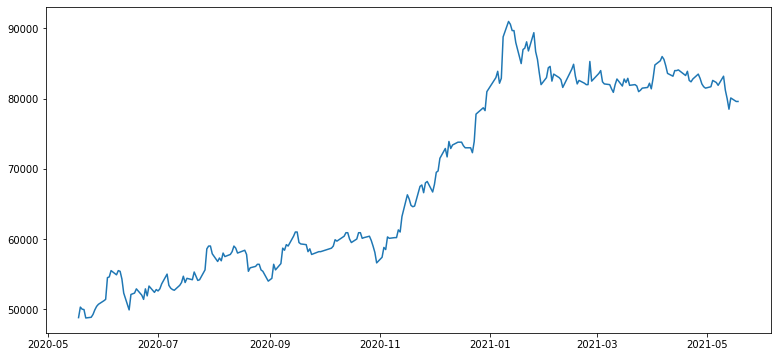

In [4]:
plt.plot(ts)

(그래프를 보면 주식데이터이다 보니 다소 불안정한 시계열 데이터임을 확인 할 수 있다)

그리고 나서 결측치를 확인하겠습니다.

In [5]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

다행히 결측치는 없는 것으로 확인됩니다.
<br>
<br>

다음으로 시각화를 통해 안정성(Stationarity) 여부를 확인하기 위해 메서드를 호출하고 함수를 정의하겠습니다.
- 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 선언
- statsmodels 패키지와 adfuller 메서드 호출
- augmented_dickey_fuller_test 함수 선언

In [6]:
from matplotlib.pylab import rcParams

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# augmented_dickey_fuller_test
# statsmodels 패키지와 adfuller 메서드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Step 2 : 각종 전처리

In [7]:
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [8]:
# 결측치 처리 / 없었지만 소스코드는 살려둡니다.
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [9]:
# 로그 변환 
ts_log = np.log(ts)

Step 3 : 시계열 안정성 분석

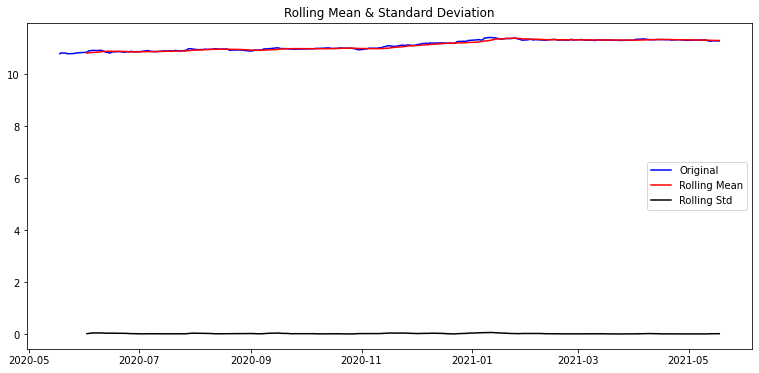

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [11]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


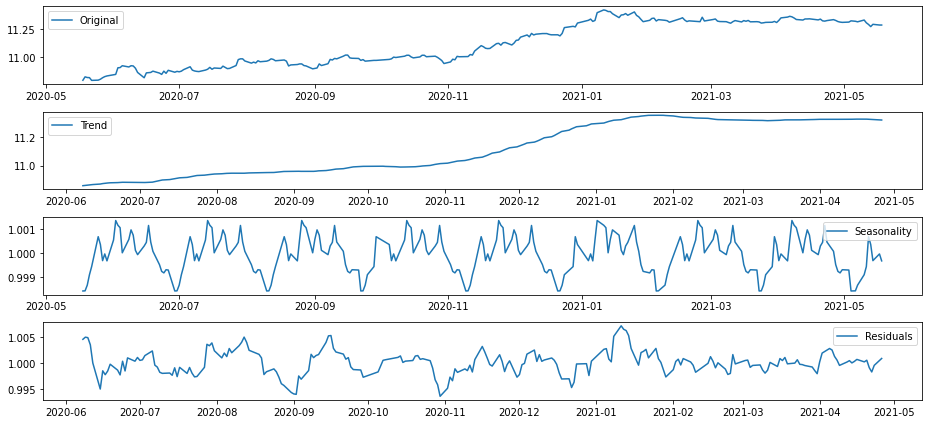

In [12]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지 = Residual

In [13]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


✅ 검정통계량이 Critical Value보다 작거나 p-value가 0에 가깝기 때문에 정상적인 시계열 데이터라고 볼 수 있다.

Step 4 : 학습, 테스트 데이터셋 생성

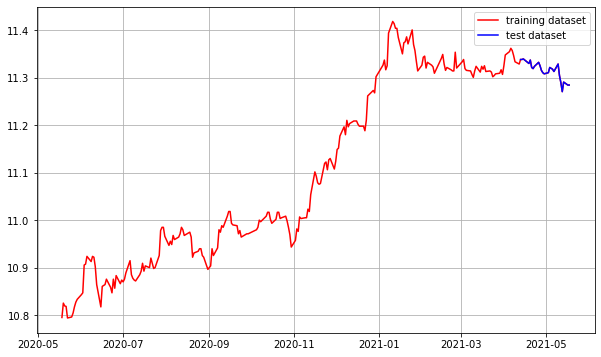

In [14]:
# 학습/테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

Step 5 : 적정 ARIMA 모수 찾기

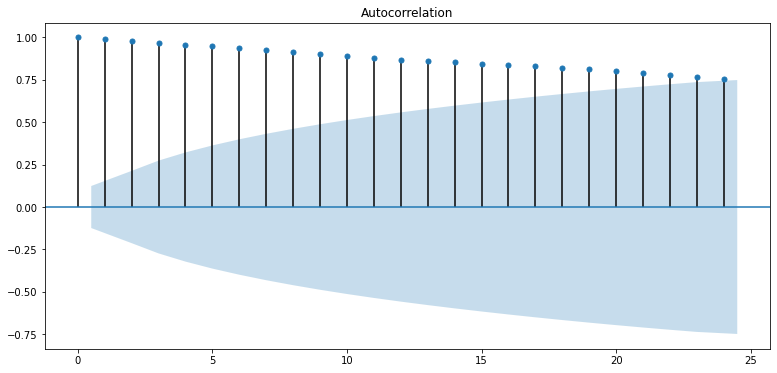

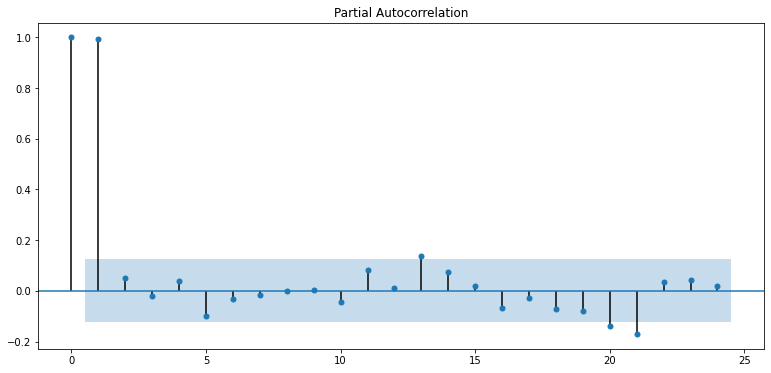

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다.  
이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

* AR(p)|PACF(우하향) - 시차 p 이후에 0
* MA(q)|ACF(우하향) - 시차 q 이후에 0

✅ p=2부터 0에 가까운 값을 보이기 때문에 p=2 / q=0 으로 정하기로 합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


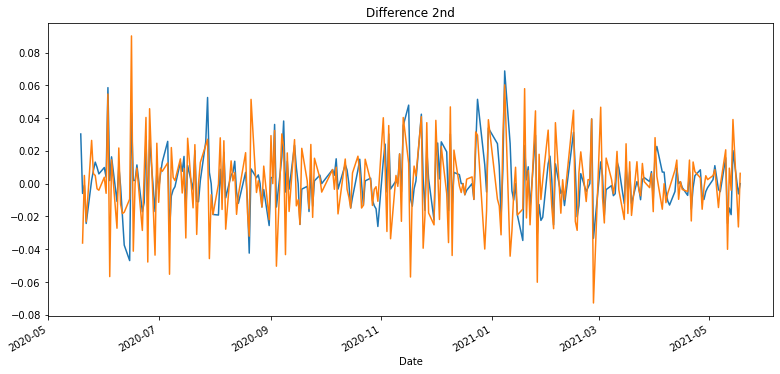

In [16]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

✅ 1차 차분만으로도 p-value의 값이 충분함을 확인하였기 때문에 d=1로 설정하기로 한다.

Step 6 : ARIMA 모델 훈련과 테스트

In [17]:
# ARIMA 모델 빌드와 훈련

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  # 기존 설정했던 p=2, q=1, d=0 에서는 만족할만한 결과를 얻지 못해 수정했습니다.
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        08:50:42   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


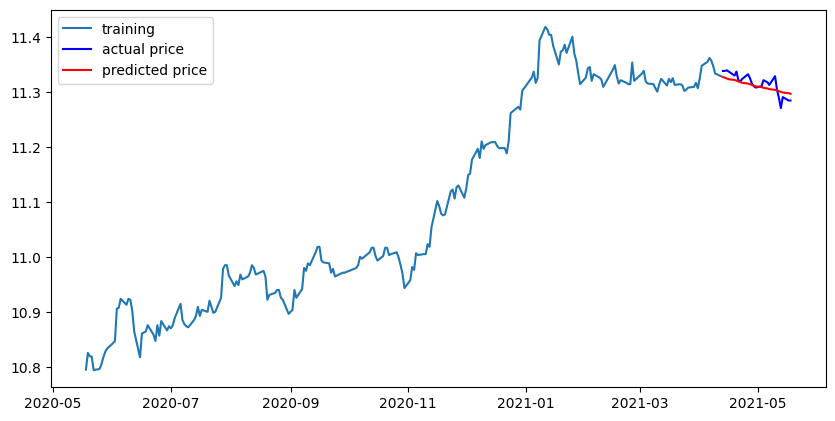

In [18]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014240584
MAE:  843.7579531509296
RMSE:  1024.194122920093
MAPE: 1.03%


✅ MAPE기준 오차율 1.03%로 만족할 만한 결과라고 본다.

---
---


# 2nd try - MSFT.CSV / microsoft

---
Step 1 : 데이터 준비  

---

In [20]:
dataset_filepath = '/content/drive/MyDrive/Exploration/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-09-29    284.000000
2021-09-30    281.920013
2021-10-01    289.100006
2021-10-04    283.109985
2021-10-05    288.760010
Name: Close, dtype: float64

In [21]:
print(type(ts))

<class 'pandas.core.series.Series'>


Date 컬럼을 index_col로 지정하고 시계열 데이터임을 확인했습니다.

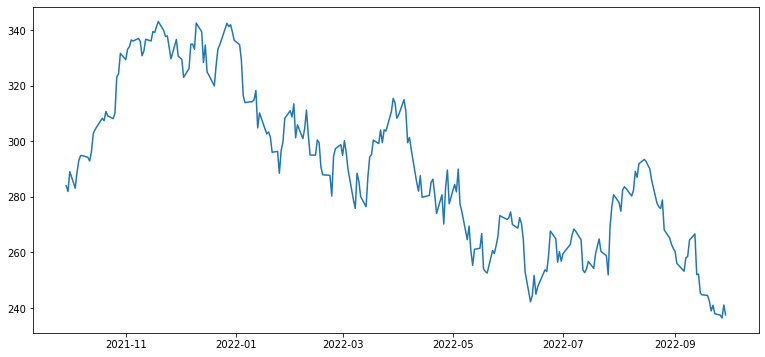

In [22]:
plt.plot(ts)

(그래프를 보면 주식데이터이다 보니 다소 불안정한 시계열 데이터임을 확인 할 수 있다)

그리고 나서 결측치를 확인하겠습니다.

In [23]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

다행히 결측치는 없는 것으로 확인됩니다.
<br>
<br>

다음으로 시각화를 통해 안정성(Stationarity) 여부를 확인하기 위해 메서드를 호출하고 함수를 정의하겠습니다.
- 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 선언
- statsmodels 패키지와 adfuller 메서드 호출
- augmented_dickey_fuller_test 함수 선언

In [24]:
from matplotlib.pylab import rcParams

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# augmented_dickey_fuller_test
# statsmodels 패키지와 adfuller 메서드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Step 2 : 각종 전처리

In [25]:
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-29,285.100006,286.769989,283.010010,284.000000,281.641266,26353700
2021-09-30,285.709991,287.829987,281.619995,281.920013,279.578522,32343600
2021-10-01,282.119995,289.980011,281.290009,289.100006,286.698914,30086300
2021-10-04,287.399994,287.750000,280.250000,283.109985,280.758636,31350700
2021-10-05,284.049988,290.399994,284.049988,288.760010,286.361725,24993000


In [26]:
# 결측치 처리 / 없었지만 소스코드는 살려둡니다.
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [27]:
# 로그 변환 
ts_log = np.log(ts)

Step 3 : 시계열 안정성 분석

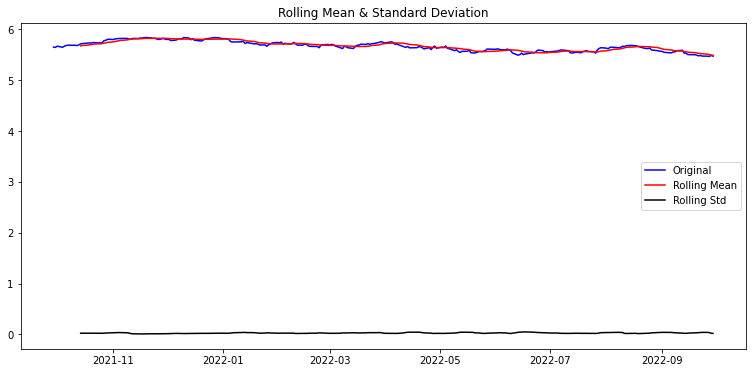

In [28]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [29]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.960553
p-value                          0.767379
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


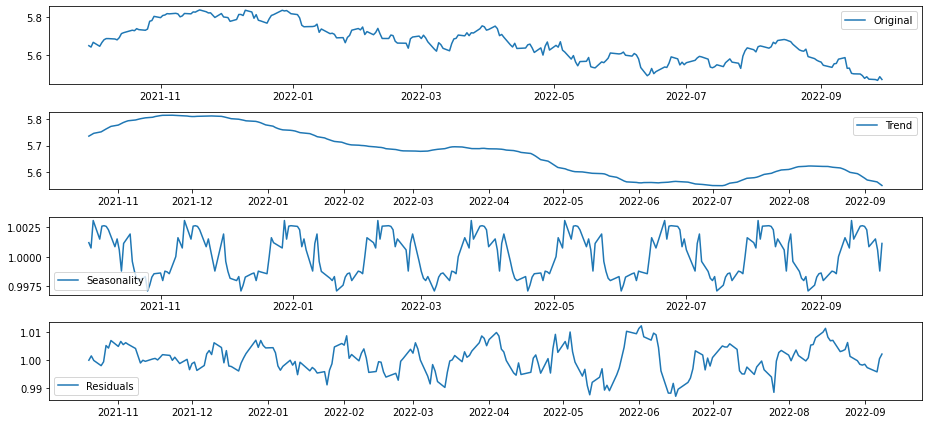

In [30]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지 = Residual

In [31]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.066130e+00
p-value                        1.180620e-07
#Lags Used                     1.000000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


✅ 검정통계량(Test Statistic)이 Critical Value보다 작거나  
✅ p-value가 0에 가깝기 때문에 정상적인 시계열 데이터라고 볼 수 있다.

Step 4 : 학습, 테스트 데이터셋 생성

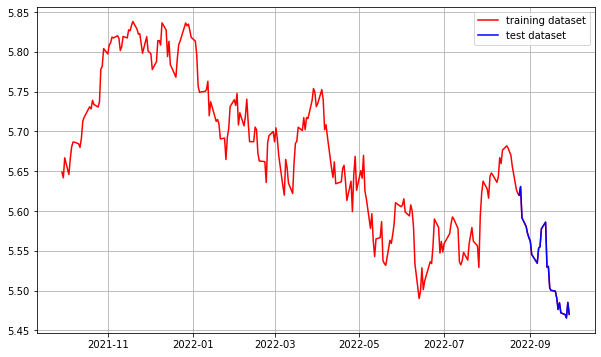

In [32]:
# 학습/테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

Step 5 : 적정 ARIMA 모수 찾기

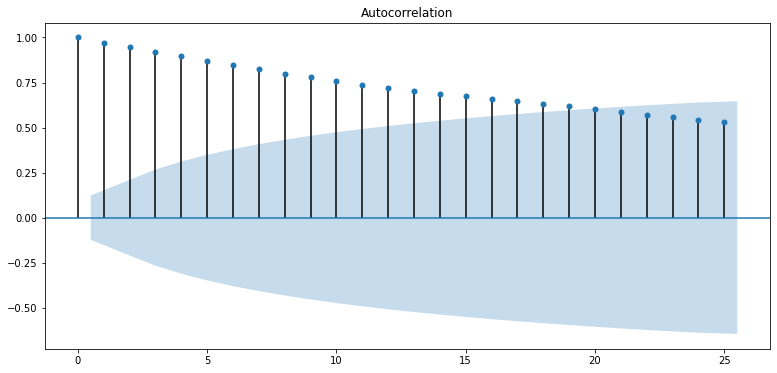

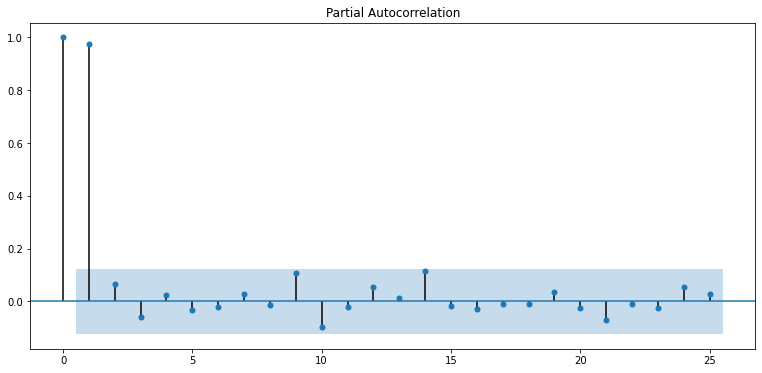

In [33]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다.  
이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

* AR(p)|PACF(우하향) - 시차 p 이후에 0
* MA(q)|ACF(우하향) - 시차 q 이후에 0

ACF 프래프를 보면 우하향 하는 경향을 관찰 할 수 있습니다. 따라서 AR 모형을 선택하고 PACF 그래프를 보면 시차 1 이후에 0에 수렴함을 볼 수 있습니다.
따라서 p, q는 1, 0으로 결정합니다.

✅ p=2부터 0에 가까운 값을 보이기 때문에 일단 p=1 / q=0 으로 결정합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.689180e+01
p-value                        1.043734e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.191976e+00
p-value                        2.111341e-15
#Lags Used                     8.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


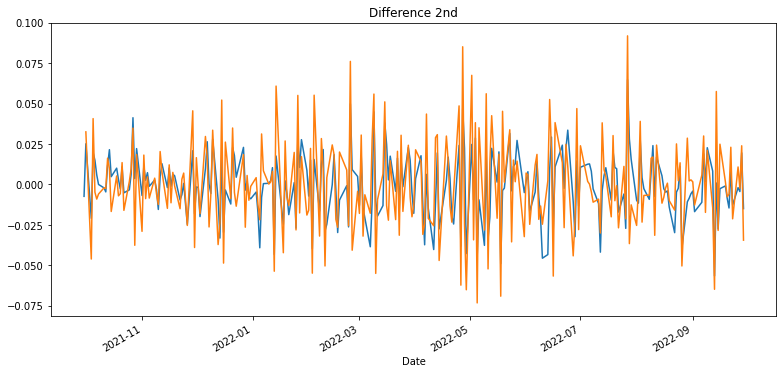

In [34]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

✅ 1차 차분에서 p-value의 값이 충분히 0에 한없이 가까움을 확인하였기 때문에 d=1로 설정하기로 한다.

Step 6 : ARIMA 모델 훈련과 테스트

In [35]:
# ARIMA 모델 빌드와 훈련

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 566.679
Date:                Fri, 30 Sep 2022   AIC                          -1129.358
Time:                        08:50:47   BIC                          -1122.517
Sample:                             0   HQIC                         -1126.597
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0685      0.061     -1.121      0.262      -0.188       0.051
sigma2         0.0004   3.59e-05     10.811      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


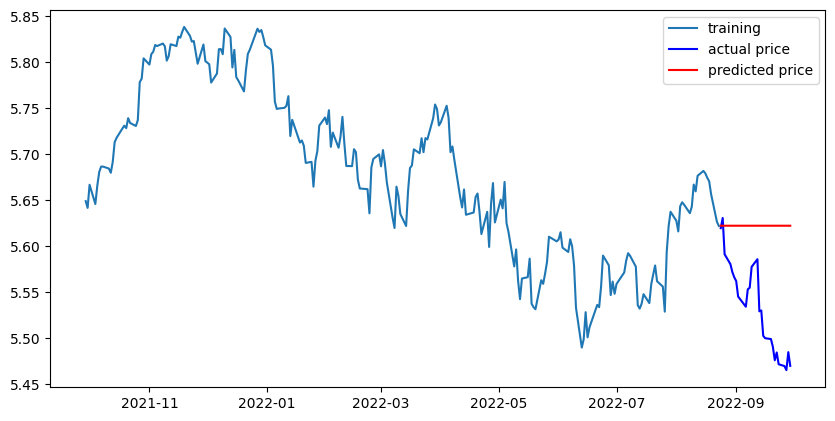

In [36]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [37]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  699.2858114277158
MAE:  23.571805144683324
RMSE:  26.444012770903658
MAPE: 9.56%


✅ MAPE기준 오차율 9.56%  
 → 기준은 맞췄지만, 그래프가 다소 납득하기 힘든 형태라서 ARIMA의 모수를 다양하게 조절해가면서 노력했지만 어째서인지 만족할만한 예측을 얻을 순 없었습니다.

---
---


# 3rd try - LCID.CSV / lucid group

---
Step 1 : 데이터 준비  

---

In [38]:
dataset_filepath = '/content/drive/MyDrive/Exploration/data/LCID.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-09-29    26.280001
2021-09-30    25.379999
2021-10-01    24.610001
2021-10-04    24.139999
2021-10-05    24.020000
Name: Close, dtype: float64

In [39]:
print(type(ts))

<class 'pandas.core.series.Series'>


Date 컬럼을 index_col로 지정하고 시계열 데이터임을 확인했습니다.

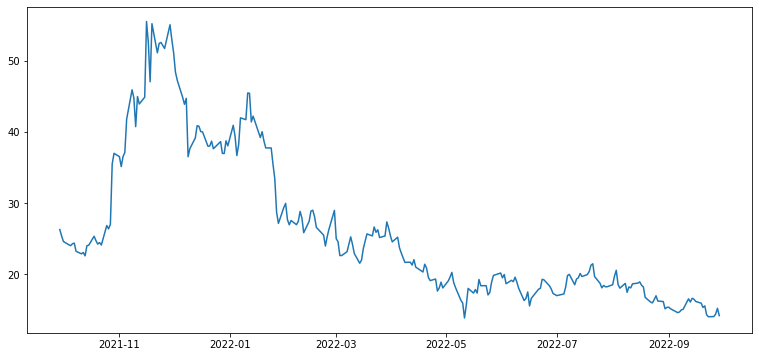

In [40]:
plt.plot(ts)

(그래프를 보면 주식데이터이다 보니 다소 불안정한 시계열 데이터임을 확인 할 수 있다)

그리고 나서 결측치를 확인하겠습니다.

In [41]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

다행히 결측치는 없는 것으로 확인됩니다.
<br>
<br>

다음으로 시각화를 통해 안정성(Stationarity) 여부를 확인하기 위해 메서드를 호출하고 함수를 정의하겠습니다.
- 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 선언
- statsmodels 패키지와 adfuller 메서드 호출
- augmented_dickey_fuller_test 함수 선언

In [42]:
from matplotlib.pylab import rcParams

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


# augmented_dickey_fuller_test
# statsmodels 패키지와 adfuller 메서드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Step 2 : 각종 전처리

In [43]:
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-29,26.450001,28.389999,26.010000,26.280001,26.280001,120691800
2021-09-30,27.122000,27.139999,25.090000,25.379999,25.379999,46844000
2021-10-01,25.510000,25.750000,24.209999,24.610001,24.610001,30696100
2021-10-04,24.760000,25.030001,23.535000,24.139999,24.139999,28779600
2021-10-05,24.180000,24.785000,23.860001,24.020000,24.020000,21742700


In [44]:
# 결측치 처리 / 없었지만 소스코드는 살려둡니다.
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [45]:
# 로그 변환 
ts_log = np.log(ts)

Step 3 : 시계열 안정성 분석

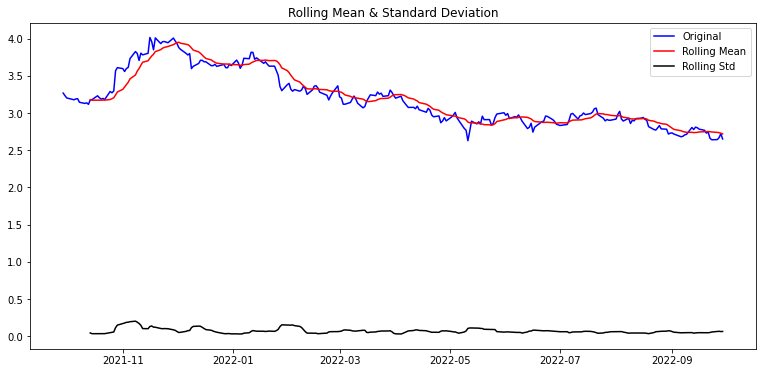

In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [47]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.815520
p-value                          0.814521
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


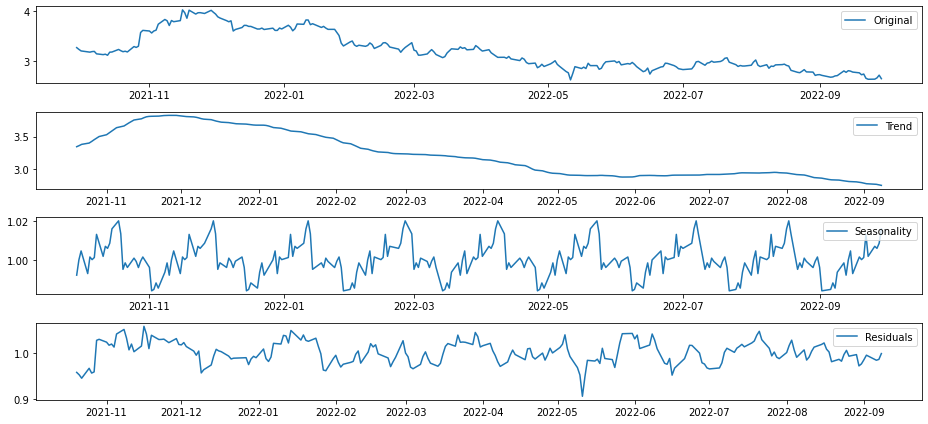

In [48]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지 = Residual

In [49]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.033955e+00
p-value                        1.396429e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


✅ 검정통계량(Test Statistic)이 Critical Value보다 작거나  
✅ p-value가 0에 가깝기 때문에 정상적인 시계열 데이터라고 볼 수 있다.

Step 4 : 학습, 테스트 데이터셋 생성

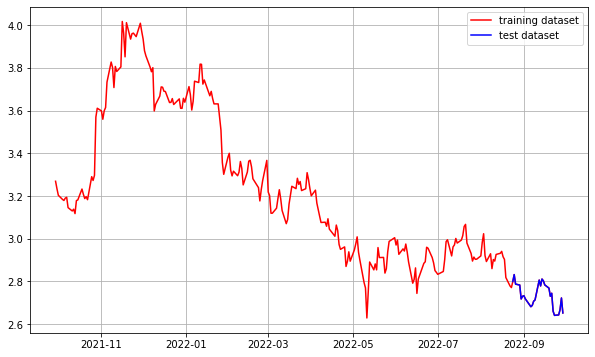

In [50]:
# 학습/테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

Step 5 : 적정 ARIMA 모수 찾기

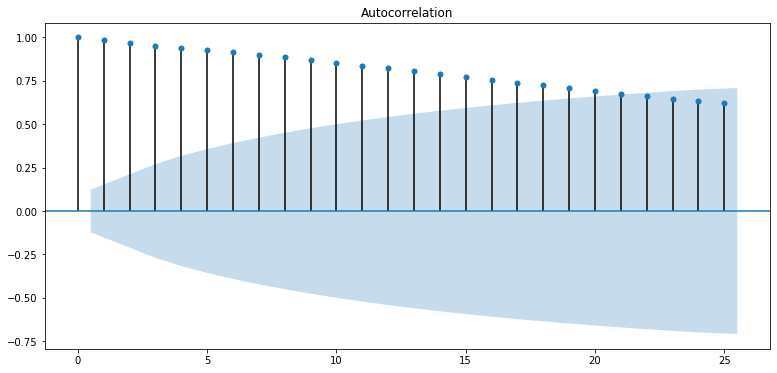

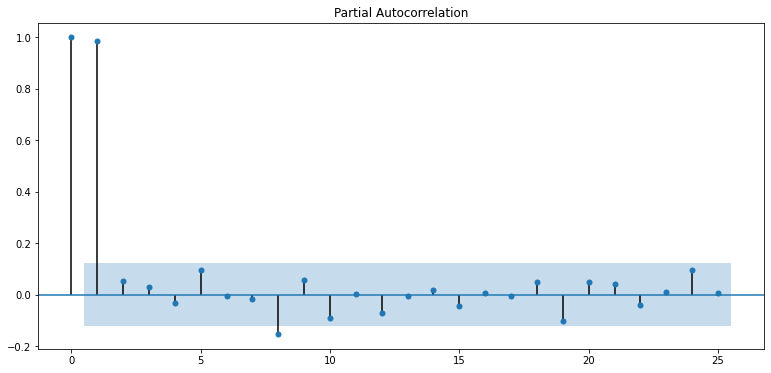

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다.  
이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

* AR(p)|PACF(우하향) - 시차 p 이후에 0
* MA(q)|ACF(우하향) - 시차 q 이후에 0

ACF 프래프를 보면 우하향 하는 경향을 관찰 할 수 있습니다. 따라서 AR 모형을 선택하고 PACF 그래프를 보면 시차 1 이후에 0에 수렴함을 볼 수 있습니다.
따라서 p, q는 1, 0으로 결정합니다.

✅ p=1이후부터 0에 가까운 값을 보이기 때문에 일단 p=1 / q=0 으로 결정합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.605338e+01
p-value                        5.742093e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.156094e+00
p-value                        2.607451e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


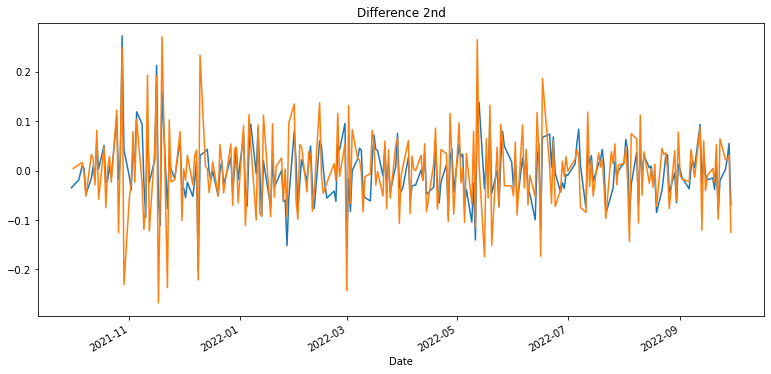

In [52]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

✅ 1차 차분에서 p-value의 값이 충분히 0에 한없이 가까움을 확인하였기 때문에 d=1로 설정하기로 한다.

Step 6 : ARIMA 모델 훈련과 테스트

In [53]:
# ARIMA 모델 빌드와 훈련

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 320.263
Date:                Fri, 30 Sep 2022   AIC                           -636.527
Time:                        08:50:52   BIC                           -629.686
Sample:                             0   HQIC                          -633.766
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0118      0.065     -0.181      0.856      -0.139       0.116
sigma2         0.0034      0.000     16.000      0.000       0.003       0.004
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


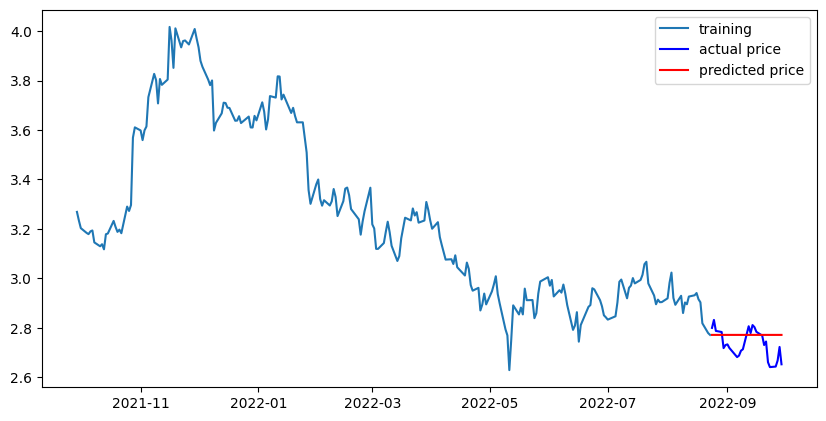

In [54]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [55]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.037124583398636
MAE:  0.8523516766070279
RMSE:  1.01839313793772
MAPE: 5.71%


✅ MAPE기준 오차율 5.71%  
 → 3rd try역시 MAPE기준 오차율은 맞췄지만, 만족할만한 결과는 아닙니다.

# 마치며, 느낀 부분
이 외에도 여러가지의 csv를 사용하여 ARIMA 모델을 공부해봤는데, 진행하며 이해가 잘 되지 않고 납득되지 않는 부분이 너무 많았다.
- ACF / PACF 그래프가 전부 비슷하다..!  
 - 이런 이유로 인해 p, q 값은 거의 고정적으로 산출할 수 밖에 없었고, 결과적으로 예측 그래프는 직관적이지 않게 그려지며 오차율은 낮지만 결과를 신뢰 할 수 없었다.  
 - 배우고 이해한대로 그래프를 해석한건데, 어떤 부분을 놓친 것일까?
- 주식데이터
 - 마찬가지로 모든 데이터에 대해서 Test Statistic 값이나 p-value를 관찰한 결과 정상적인 시계열 데이터임을 확인 할 수 있었다. 하지만 이러한 결과값은 내게 '블랙박스'를 통과한 결과값이라서 쉽게 납득 할 수 없는 부분이라 다소 찝찝하고 신뢰하기 어려웠다.
- ARIMA의 모수 찾기
 - 위에서 말한 것들을 토대로 ARIMA의 모수 p d q를 직접 수정해가며 결과를 얻어봤는데, 아이러니 하게도 값은 신뢰 할 수 없었지만 대부분은 그래프와 차분 결과로 얻은 값들에서 낮은 오차율은 확인 할 수 있었다(...)

ARIMA 모델을 학습하고 사용해본 것에 의미가 있었지만, 좀 더 자주적인 학습을 통해 내용을 이해 할 필요가 있다고 느꼈다.